In [26]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from copy import deepcopy

import olympus
from olympus.scalarizers import Scalarizer
from olympus.datasets import Dataset

In [27]:
def get_traces(data, scalarizer):
    ''' returns the best merit traces
    '''
    traces = []
    for df in data:
        scalarized = scalarizer.scalarize(df.loc[:, [ 'drug_loading', 'encap_efficiency', 'particle_diameter']].values)
        trace_best_idx = [np.argmin(scalarized[:i+1]) for i in range(len(scalarized))]
        trace0 = [df.loc[i, 'drug_loading'] for i in trace_best_idx]
        trace1 = [df.loc[i, 'encap_efficiency'] for i in trace_best_idx]
        trace2 = [df.loc[i, 'particle_diameter'] for i in trace_best_idx]
        traces.append([trace0, trace1, trace2])
    return np.array(traces)


def get_frac_tol(data):
    ''' returns the fraction of tolerable molecules uncovered at each iteration
    '''
    traces = []
    df_tol = df_results[
            (df_results['ered']>chimera.tolerances[0])&
            (df_results['gsol']<chimera.tolerances[1])&
            (df_results['abs_lam_diff']>chimera.tolerances[2])
        ]
    for df in data:
        frac_tols  = []
        for i in range(df.shape[0]): 
            sub_df = df.iloc[:i+1, :]
            data_tol = sub_df[
                    (sub_df['ered']>chimera.tolerances[0])&
                    (sub_df['gsol']<chimera.tolerances[1])&
                    (sub_df['abs_lam_diff']>chimera.tolerances[2])
                ]
            frac_tol = data_tol.shape[0] / df_tol.shape[0]
            frac_tols.append(frac_tol)
        traces.append(frac_tols)
        
    return np.array(traces)   # (num_runs, num_iterations)


def get_cummin_rank(data):
    ''' returns the best achieved ranking at each iteration
    '''
    traces = []
    for df in data:
        ranks = []
        
        ids = df.loc[:, ['r1_label', 'r3_label', 'r4_label', 'r5_label']].values

        for i in range(len(ids)):
            row = df_results[
                    (df_results['r1_label']==ids[i, 0])&
                    (df_results['r3_label']==ids[i, 1])&
                    (df_results['r4_label']==ids[i, 2])&
                    (df_results['r5_label']==ids[i, 3])
                ]
            rank = row.to_dict('r')[0]['rank']
            ranks.append(rank)
        traces.append(ranks)
    
    return np.minimum.accumulate(np.array(traces), axis=1)
    
    
# def plot_trace_frac(traces, ax=None, color=None, label=None, use_std_err=True):
    
#     #traces = get_frac_tol(data)
    
#     if ax is None:
#         fig, ax = plt.subplots()
        
#     mean = np.mean(traces, axis=0)
#     if use_std_err is True:
#         stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
#     else:
#         stde = np.nanstd(traces, axis=0, ddof=1)

#     x = np.arange(1, len(mean) + 1, 1)
        
#     ax.plot(x, mean, color='#444444', linewidth=5)
#     ax.plot(x, mean, color=color, linewidth=4, label=label)
    
#     ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
#     ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
#     ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)

    
    
# def plot_trace_cummin_rank(traces, ax=None, color=None, label=None, use_std_err=True):
    
#     #traces = get_cummin_rank(data)
    
#     if ax is None:
#         fig, ax = plt.subplots()
        
#     mean = np.mean(traces, axis=0)
#     if use_std_err is True:
#         stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
#     else:
#         stde = np.nanstd(traces, axis=0, ddof=1)

#     x = np.arange(1, len(mean) + 1, 1)
        
#     ax.plot(x, mean, color='#444444', linewidth=5)
#     ax.plot(x, mean, color=color, linewidth=4, label=label)
    
#     ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color)
#     ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5)
#     ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5)
    
    
    
def plot_trace_mean(data, scalarizer, obj_num=0, ax=None, color=None, label=None, use_std_err=True):
        
    traces = get_traces(data, scalarizer)[:, obj_num, :]
    if ax is None:
        fig, ax = plt.subplots()
    
    mean = np.mean(traces, axis=0)
    if use_std_err is True:
        stde = np.std(traces, axis=0, ddof=1) / np.sqrt(np.shape(traces)[0] - 1)
    else:
        stde = np.nanstd(traces, axis=0, ddof=1)

    x = np.arange(1, len(mean) + 1, 1)
        
    ax.plot(x, mean, color='#444444', linewidth=5, zorder=11)
    ax.plot(x, mean, color=color, linewidth=4, label=label, zorder=11)
    
    ax.fill_between(x, y1=mean-1.96*stde, y2=mean+1.96*stde, alpha=0.2, color=color, zorder=10)
    ax.plot(x, mean-1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)
    ax.plot(x, mean+1.96*stde, color=color, linewidth=1, alpha=0.5, zorder=10)


# def plot_trace_sigle(pkl_file, ax, obj_name, goal='min', color='k', label='', shift=0.0, use_std_err=True):
#     with open(pkl_file, 'rb') as content:
#         data = pickle.load(content)
#     plot_trace_mean(data, obj_name, goal=goal, ax=ax, color=color, label=label, shift=shift, use_std_err=use_std_err)
    

def gradient_patch(ax, xmin, xmax, ymin, ymax, fill_color='k', alpha=1, zorder=1):
    
    x = np.linspace(xmin, xmax, 100)
    y = np.linspace(ymin, ymax, 100)
    
    z = np.empty((100, 1, 4), dtype=float)
    rgb = mcolors.colorConverter.to_rgb(fill_color)
    z[:,:,:3] = rgb
    z[:,:,-1] = np.linspace(0, alpha, 100)[:,None]

    im = ax.imshow(z, aspect='auto', extent=[xmin, xmax, ymin, ymax],
                   origin='lower', zorder=zorder)

    xy = np.column_stack([x, y])
    xy = np.vstack([[xmin, ymin], xy, [xmax, ymin], [xmin, ymin]])
    clip_path = Rectangle(xy=(xmin, ymin), width=xmax-xmin, height=ymax-ymin, 
                          facecolor='none', edgecolor='none')
    ax.add_patch(clip_path)
    im.set_clip_path(clip_path)

In [15]:
def num_eval_to_x(res, pd, dl, ee):
    num_evals = []
    for r in res:
        good_evals = r.index[(r['particle_diameter']<=np.log10(pd))&(r['drug_loading']>=dl)&(r['encap_efficiency']>=ee)].tolist()
        if not good_evals == []:
            num_evals.append(np.amin(good_evals)+1)
        else:
            num_evals.append(r.shape[0]) # budget evals
    return num_evals, np.mean(num_evals), np.median(num_evals), np.std(num_evals)

In [34]:
# load resulsts
raw_res_rand = pickle.load(open('../random/results.pkl', 'rb'))
raw_res_bo_1 = pickle.load(open('../botorch/results.pkl', 'rb'))
# raw_res_hyper_1 = pickle.load(open('../hyperopt/results.pkl', 'rb'))
raw_res_gpyopt_1 = pickle.load(open('../gpyopt/results.pkl', 'rb'))

print(len(raw_res_rand))
print(len(raw_res_bo_1))
# print(len(raw_res_hyper_1))
print(len(raw_res_gpyopt_1))

dataset = Dataset('lnp3')

param_names = ['drug_input', 'solid_lipid', 'solid_lipid_input', 'liquid_lipid_input', 'surfractant_input']
obj_names = ['drug_loading', 'encap_efficiency', 'particle_diameter']

scalarizer = Scalarizer(
        kind='Hypervolume',
        value_space=dataset.value_space,
        goals=['max', 'max', 'min'],
    )


def unpack_results(res):
    
    num_iter = res[0].shape[0]
    new_dfs = []
    
    for ix in range(len(res)):
        r = res[ix]
        scal = scalarizer.scalarize(
            r.loc[:, ['drug_loading', 'encap_efficiency', 'particle_diameter']].values
        )
        trace_best_ix = [np.argmin(scal[:i+1]) for i in range(len(scal))]
        trace0 = [r.loc[i, 'drug_loading'] for i in trace_best_ix]
        trace1 = [r.loc[i, 'encap_efficiency'] for i in trace_best_ix]
        trace2 = [r.loc[i, 'particle_diameter'] for i in trace_best_ix] 
        r['iter'] = np.arange(r.shape[0])+1
        r['repeat'] = ix
        r['best_drug_loading'] = trace0
        r['best_encap_efficiency'] = trace1
        r['best_particle_diameter'] = 10**np.array(trace2)
        new_dfs.append(r)
        
    return pd.concat(new_dfs, ignore_index=True)
        
        
res_rand = unpack_results(raw_res_rand)
res_bo_1 = unpack_results(raw_res_bo_1)
# res_hyper_1 = unpack_results(raw_res_hyper_1)
res_gpyopt_1 = unpack_results(raw_res_gpyopt_1)

40
13
20


In [35]:
pdi = 15
dl = 0.19
ee = 0.6

num_evals_rand, mean_rand, med_rand, _ = num_eval_to_x(raw_res_rand, pdi, dl, ee)
num_evals_bo_1, mean_bo_1, med_bo_1, _ = num_eval_to_x(raw_res_bo_1, pdi, dl, ee)
num_evals_gpyopt_1, mean_gpyopt_1, med_gpyopt_1, _ = num_eval_to_x(raw_res_gpyopt_1, pdi, dl, ee)

num_evals_list = []
for n in num_evals_rand:
    num_evals_list.append({'method': 'rand', 'num_evals': n})
for n in num_evals_bo_1:
    num_evals_list.append({'method': 'bo_1', 'num_evals': n})
for n in num_evals_gpyopt_1:
    num_evals_list.append({'method': 'gpyopt_1', 'num_evals': n})

num_evals = pd.DataFrame(num_evals_list)

max drug_loading :  0.2018981967587141
max encap_efficiency :  0.6464171735334162
min |300nm-particle_diameter| :  0.3971169650589185


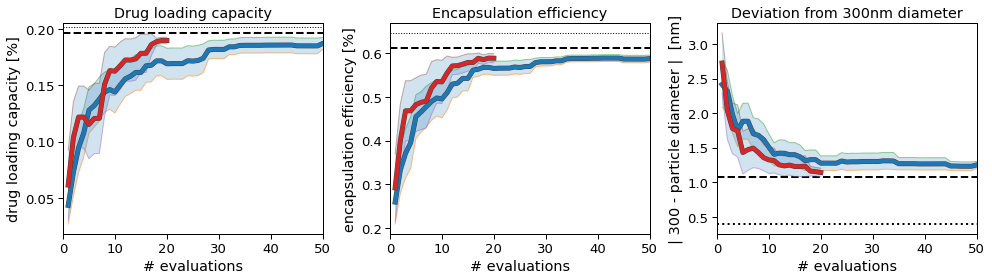

In [39]:
fig, (ax0, ax1, ax2) = plt.subplots(1, 3, figsize=(14, 4))

max_drug_loading = dataset.data.drug_loading.max()
max_encap_efficiency = dataset.data.encap_efficiency.max()
min_particle_diameter = dataset.data.particle_diameter.min()
print('max drug_loading : ', max_drug_loading)
print('max encap_efficiency : ', max_encap_efficiency)
print('min |300nm-particle_diameter| : ', min_particle_diameter)

params = dataset.data[param_names].values
values = dataset.data[obj_names].values

scalarizer = Scalarizer(kind='Hypervolume', value_space=dataset.value_space, goals=['max', 'max', 'min'])
scalarized = scalarizer.scalarize(values)

idx = np.argsort(scalarized)
sort_params = params[idx]
sort_values = values[idx]
sort_scalarized = scalarized[idx]

best_objs = sort_values[0]



plot_trace_mean(raw_res_rand, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_gpyopt_1, scalarizer, obj_num=0, ax=ax0, color=None, use_std_err=True, label='Gpyopt')

ax0.axhline(best_objs[0],c='k',lw=2,ls='--') # overall best
ax0.axhline(max_drug_loading,c='k',lw=1,ls=':') # single best



plot_trace_mean(raw_res_rand, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_gpyopt_1, scalarizer, obj_num=1, ax=ax1, color=None, use_std_err=True, label='Gpyopt')

ax1.axhline(best_objs[1],c='k',lw=2,ls='--')
ax1.axhline(max_encap_efficiency,c='k',lw=1,ls=':') # single best

plot_trace_mean(raw_res_rand, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Random')
plot_trace_mean(raw_res_gpyopt_1, scalarizer, obj_num=2, ax=ax2, color=None, use_std_err=True, label='Gpyopt')

ax2.axhline(best_objs[2],c='k',lw=2,ls='--')
ax2.axhline(min_particle_diameter,c='k',lw=2,ls=':') # single best

ax0.set_title('Drug loading capacity')
ax1.set_title('Encapsulation efficiency')
ax2.set_title('Deviation from 300nm diameter')

# ax2.set_yscale('log')

ax0.set_xlabel('# evaluations')
ax1.set_xlabel('# evaluations')
ax2.set_xlabel('# evaluations')

ax0.set_ylabel('drug loading capacity [%]')
ax1.set_ylabel('encapsulation efficiency [%]')
ax2.set_ylabel('| 300 - particle diameter |  [nm]')


ax0.set_xlim(0, 50)
ax1.set_xlim(0, 50)
ax2.set_xlim(0, 50)# overall best

plt.tight_layout()

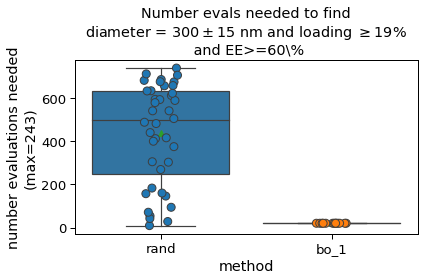

In [39]:
fig, ax0 = plt.subplots(1, 1, figsize=(6, 4))

sns.boxplot(data=num_evals, x='method', y='num_evals', showmeans=True)
sns.stripplot(data=num_evals, x='method', y='num_evals', edgecolor='gray', linewidth=1, size=8)

ax0.set_ylabel('number evaluations needed\n(max=243)')
ax0.set_xlabel('method')

ax0.set_title(f'Number evals needed to find\n'+f'diameter = $300\pm15$ nm'+f' and loading $\geq 19\%$\n' ' and EE>=60\%')

plt.tight_layout()
#plt.savefig('num_evals_needed_three_obj.png', dpi=400)

In [58]:
print(mean_bo_5, mean_grid, mean_rand)
print(med_bo_5, med_grid, med_rand)

34.0625 166.46 233.78
39.5 203.5 243.0


In [59]:
166.46/34.0625

4.8868990825688075

In [60]:
203.5/39.5

5.151898734177215

In [18]:
raw_res_bo_5[0][:20]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,iter,repeat,best_drug_loading,best_encap_efficiency,best_particle_diameter
0,40.78502708525248,Stearic_acid,72.69180426450558,1.0445863316699278,0.009222401148508513,0.095722,0.444085,3.599334,1,0,0.095722,0.444085,3974.971684
1,15.011150158460772,Glyceryl_monostearate,76.29766192361798,22.808341205305574,0.00122185714528544,0.021189,0.138965,1.793710,2,0,0.021189,0.138965,62.188481
2,31.502083398193342,Glyceryl_monostearate,111.91839889991843,30.007259687804645,0.00861079122041011,0.042604,0.326840,3.568588,3,0,0.021189,0.138965,62.188481
3,27.977215351941993,Stearic_acid,102.54941230198952,3.987932607284691,0.0013175961569535822,0.045862,0.256277,3.221874,4,0,0.045862,0.256277,1666.762796
4,15.723791876247898,Compritol_888,92.69488274735639,18.84393212398025,0.00947678017570934,0.053893,0.426643,1.335646,5,0,0.053893,0.426643,21.659365
5,28.206312691762314,Glyceryl_monostearate,97.63915769515468,15.756495859496075,0.0075296501193105134,0.037230,0.326745,3.607264,6,0,0.053893,0.426643,21.659365
6,41.58703799030376,Glyceryl_monostearate,95.75532807347746,27.40262063845328,0.00021412949128937287,0.059361,0.168649,1.686025,7,0,0.053893,0.426643,21.659365
7,16.03110091343458,Glyceryl_monostearate,79.65429371574865,41.921573608307675,0.004250116767912519,0.019132,0.189447,3.462157,8,0,0.053893,0.426643,21.659365
8,35.87206276548214,Glyceryl_monostearate,102.52935366473434,1.175604186699958,0.006495072661474646,0.056039,0.359973,3.401749,9,0,0.053893,0.426643,21.659365
9,14.549496145395983,Glyceryl_monostearate,102.20048766604668,21.061074893862113,0.0028338588380805666,0.020043,0.178999,3.193125,10,0,0.053893,0.426643,21.659365


In [ ]:
raw_res_

In [17]:
raw_res_grid[0][:20]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,iter,repeat,best_drug_loading,best_encap_efficiency,best_particle_diameter
0,6.0,Glyceryl_monostearate,72.0,0.0,0.005,0.007880,0.159127,3.563363,1,0,0.007880,0.159127,3659.003960
1,27.0,Glyceryl_monostearate,72.0,0.0,0.01,0.030030,0.342896,3.637145,2,0,0.007880,0.159127,3659.003960
2,6.0,Compritol_888,120.0,48.0,0.005,0.012764,0.275794,1.228923,3,0,0.012764,0.275794,16.940375
3,6.0,Stearic_acid,120.0,24.0,0.005,0.008533,0.171401,3.602286,4,0,0.012764,0.275794,16.940375
4,6.0,Glyceryl_monostearate,120.0,0.0,0.0,0.003718,0.099781,1.229601,5,0,0.012764,0.275794,16.940375
5,27.0,Compritol_888,72.0,24.0,0.0,0.027422,0.122427,1.080762,6,0,0.012764,0.275794,16.940375
6,6.0,Compritol_888,72.0,0.0,0.0,0.002860,0.051994,0.983459,7,0,0.012764,0.275794,16.940375
7,27.0,Stearic_acid,72.0,0.0,0.0,0.022749,0.130447,3.147790,8,0,0.012764,0.275794,16.940375
8,6.0,Glyceryl_monostearate,96.0,24.0,0.01,0.004283,0.170614,3.640681,9,0,0.012764,0.275794,16.940375
9,48.0,Stearic_acid,120.0,0.0,0.01,0.119169,0.429281,3.560095,10,0,0.012764,0.275794,16.940375


In [16]:
raw_res_bo_1[0][:20]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,iter,repeat,best_drug_loading,best_encap_efficiency,best_particle_diameter
0,26.69313635860152,Compritol_888,80.04910475482109,29.54908568178165,0.00036874038206601955,0.036922,0.136099,1.314010,1,0,0.036922,0.136099,20.606757
1,23.779176712036133,Stearic_acid,113.8686294555664,11.757627487182617,0.0050566899590194225,0.060648,0.351256,3.536146,2,0,0.036922,0.136099,20.606757
2,40.254157919502134,Stearic_acid,96.46377232885088,17.235026997978498,0.003412644945721633,0.118267,0.446818,3.445860,3,0,0.118267,0.446818,2791.641992
3,45.630349277132424,Stearic_acid,102.7468196902384,28.03244304839562,0.00474732755143189,0.164404,0.484204,3.466999,4,0,0.164404,0.484204,2930.883899
4,48.0,Glyceryl_monostearate,115.10082798384575,17.036296943056033,0.005528089814996825,0.083697,0.382566,3.230367,5,0,0.164404,0.484204,2930.883899
5,48.0,Glyceryl_monostearate,120.0,4.4381052433095647e-07,0.01,0.075096,0.396444,3.603949,6,0,0.164404,0.484204,2930.883899
6,48.0,Stearic_acid,119.02571505684381,45.374756942513386,0.004028264217049999,0.176856,0.510372,3.509346,7,0,0.164404,0.484204,2930.883899
7,44.72751251631712,Glyceryl_monostearate,72.79165919696801,8.22535789249974,0.003848458716619418,0.071611,0.261335,2.646262,8,0,0.071611,0.261335,442.855361
8,43.21563547768585,Compritol_888,72.14776154296433,39.329219816705006,0.005056717602847826,0.187733,0.592822,1.241664,9,0,0.187733,0.592822,17.444719
9,47.789004220653624,Compritol_888,72.00000000309394,42.57246839842085,0.00634811011873035,0.193896,0.602560,1.313087,10,0,0.193896,0.602560,20.563041


In [28]:
raw_res_bo_1[0]

,drug_input,solid_lipid,solid_lipid_input,liquid_lipid_input,surfractant_input,drug_loading,encap_efficiency,particle_diameter,iter,repeat,best_drug_loading,best_encap_efficiency,best_particle_diameter
0,12,Compritol_888,120,12,0.01,0.038474,0.421658,1.431102,1,0,0.038474,0.421658,26.983740
1,12,Stearic_acid,108,48,0.005,0.026973,0.283693,3.577397,2,0,0.038474,0.421658,26.983740
2,24,Glyceryl_monostearate,120,12,0.01,0.023668,0.270707,3.625360,3,0,0.038474,0.421658,26.983740
3,48,Glyceryl_monostearate,108,24,0.01,0.076790,0.394349,3.564042,4,0,0.038474,0.421658,26.983740
4,12,Stearic_acid,108,48,0.0,0.004277,0.055294,2.659573,5,0,0.038474,0.421658,26.983740
5,6,Compritol_888,96,48,0.0,0.002318,0.043930,1.306059,6,0,0.038474,0.421658,26.983740
6,6,Compritol_888,96,24,0.0,0.001205,0.024131,1.590905,7,0,0.038474,0.421658,26.983740
7,6,Glyceryl_monostearate,96,24,0.0025,0.003986,0.080031,2.096790,8,0,0.038474,0.421658,26.983740
8,48,Glyceryl_monostearate,108,24,0.0025,0.074133,0.224570,1.813341,9,0,0.038474,0.421658,26.983740
9,48,Compritol_888,72,48,0.0025,0.181256,0.553550,0.800027,10,0,0.181256,0.553550,6.309967
